In [49]:
import numpy as np
import os
import pandas as pd
import pickle
from zipfile import ZipFile

# mltoolz doesn't work for the rest of us because we don't have the file, 
# you can add it to the 'utils' folder and uncomment the 'Access to "utils"' lines

# Access to "utils"
# src_path = os.path.dirname(os.getcwd())
# if os.path.exists(src_path) and src_path not in sys.path:
#     sys.path.append(src_path)

import mltoolz as mlt # not sure if this will work for others 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
ZIP_PATH = '../data/dataset.zip'

with ZipFile(ZIP_PATH, 'r') as z:
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f, parse_dates=['date'])

In [4]:
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [5]:
df.dropna(axis=0, inplace=True)

In [6]:
df.drop('date', axis=1, inplace=True)

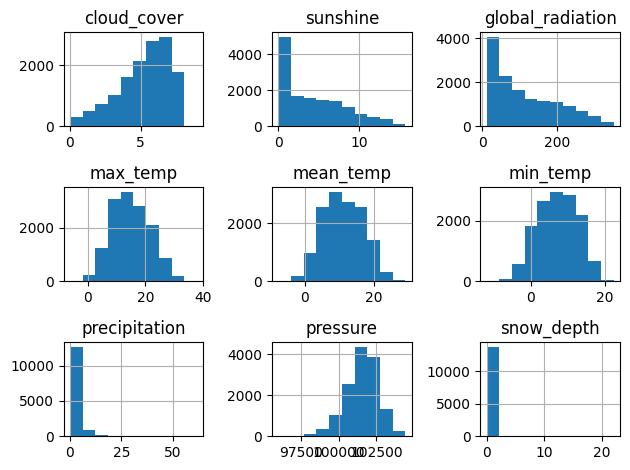

In [50]:
df.hist()
plt.tight_layout()

---
## Train, test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('precipitation', axis=1),df['precipitation'],test_size=0.2,random_state=13)

---
## Instatiate base algorithms

In [ ]:
algs = {
    'Linea Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1),
    'Lasso': Lasso(alpha=5000),
    'Random Forest': RandomForestRegressor(random_state=13, n_estimators=500)
    }

---
## Cross validate all base algorithms

In [28]:
model_names = []
mse = []
rmse = []
mape = []
pipes = {}

for name, alg in algs.items():
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', alg)
    ])

    CVresults = cross_validate(pipe, X_train, y_train, scoring=('neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'))
    
    model_names.append(name)
    mse.append(-np.mean(CVresults['test_neg_mean_squared_error']))
    rmse.append(-np.mean(CVresults['test_neg_root_mean_squared_error']))
    mape.append(-np.mean(CVresults['test_neg_mean_absolute_percentage_error']))
    pipes[name] = pipe

cvResultsDF = pd.DataFrame({
    'Model': model_names,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE': mape
})

In [44]:
cvResultsDF

,Model,MSE,RMSE,MAPE
0,LinearRegression,11.784020,3.430673,2.923844e+15
1,Ridge,11.783996,3.430670,2.923515e+15
2,Lasso,13.927176,3.729555,3.927919e+15
3,Random Forest,12.038573,3.468344,2.326076e+15


---
## Hyperparameter Tuning

In [39]:
ridge_params = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
    'regressor__fit_intercept': [True, False],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga']
}

lasso_params = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 5000, 10000]
}

rf_params = {
    'regressor__n_estimators': [50, 250, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__bootstrap': [True, False]
}

In [33]:
best_models = {}

In [47]:
for name, pipe in pipes.items():
    if name == 'LinearRegression':
        continue

    if name == 'Ridge':
        params = ridge_params
    elif name == 'Lasso':
        params = lasso_params
    elif name == 'Random Forest':
        params = rf_params
    else:
        raise ValueError(f'Unknown model name: {name}')

    print(f'Tuning {name}...')
    gs = GridSearchCV(pipes[name], param_grid=params, cv=5, scoring='neg_mean_squared_error')
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    best_models[name] = best

Tuning Ridge...
Tuning Lasso...
Tuning Random Forest...


KeyboardInterrupt: 

---
## Predict on test set and evaluate

In [ ]:
model_names = []
mse = []
rmse = []
mape = []

for name, model in best_models.items():
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', alg)
    ])

    predResults = mlt.fit_test_evaluate(pipe, X_train, y_train, X_test, y_test, metrics=('neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'), print_report=False, return_scores=True)
    
    model_names.append(name)
    mse.append(np.mean(predResults['neg_mean_squared_error']))
    rmse.append(np.mean(predResults['neg_root_mean_squared_error']))
    mape.append(np.mean(predResults['neg_mean_absolute_percentage_error']))

predResultsDF = pd.DataFrame({
    'Model': model_names,
    'MSE': mse,
    'RMSE': rmse,
    'MAPE': mape
})

In [26]:
predResultsDF

,Model,MSE,RMSE,MAPE
0,LinearRegression,11.905302,3.450406,2.952995e+15
1,Ridge,11.905480,3.450432,2.952701e+15
2,Lasso,14.004643,3.742278,3.966327e+15
3,Random Forest,11.328509,3.365785,2.308573e+15


In [51]:
best_model = best_models[predResultsDF.loc[predResultsDF['MSE'].idxmin(), 'Model']]

KeyError: 'Random Forest'

---
## Save models

In [ ]:
pickle.dump(best_model, open('../models/best_model.pkl', 'wb'))